In [184]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist, PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
# set paths to agent(s)

base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

base_name = 'ramp_job_placement_shaping'
agent_to_id = {
    # 'RL': 133,
    # 'RL': 176,
    'RL': 289,
}

In [186]:
# load data

episode_metrics = {
    'num_jobs_arrived',
    'num_jobs_completed',
    'num_jobs_blocked',
}

episode_completion_metrics = {
    'job_completion_time',
    'job_communication_overhead_time',
    'job_computation_overhead_time',
    'jobs_completed_num_nodes',
    'jobs_completed_num_edges',
    'jobs_completed_total_operation_memory_cost',
    'jobs_completed_total_dependency_size',
}

episode_blocked_metrics = {
    'jobs_blocked_num_nodes',
    'jobs_blocked_num_edges',
    'jobs_blocked_total_operation_memory_cost',
    'jobs_blocked_total_dependency_size',
}

# 'jobs_blocked_causes', # TODO: Process strings properly below when plotting
step_metrics = set()

# episode_metrics = set()
# step_metrics = set()

agent_to_episode_stats_dict = defaultdict(list)
agent_to_episode_completion_stats_dict = defaultdict(list)
agent_to_episode_blocked_stats_dict = defaultdict(list)

agent_to_step_stats_dict = defaultdict(list)

for agent, _id in agent_to_id.items():
    agent_dir = base_folder + f'{base_name}/{base_name}_{_id}/'
    if os.path.isdir(agent_dir+'checkpoints/'):
        print(f'\nLoading checkpoints from {agent_dir[:-1]}...')
        
        # get paths to checkpoints
        checkpoint_dirs = sorted(glob.glob(agent_dir+'checkpoints/*'))
        
        # load stats at each checkpoint
        for checkpoint_dir in checkpoint_dirs[:-1]:
            checkpoint = int(checkpoint_dir.split('/')[-1].split('_')[-1])
            
            completion_stats_found, blocked_stats_found = False, False
            
            # load episode stats
            with gzip.open(checkpoint_dir+'/episode_stats.pkl', 'rb') as f:
                episode_stats = pickle.load(f)
            for metric, result in episode_stats.items():
                if metric in episode_metrics:
                    try:
                        agent_to_episode_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_stats_dict[metric].append(result)
                elif metric in episode_completion_metrics:
                    completion_stats_found = True
                    try:
                        agent_to_episode_completion_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_completion_stats_dict[metric].append(result)
                elif metric in episode_blocked_metrics:
                    blocked_stats_found = True
                    try:
                        agent_to_episode_blocked_stats_dict[metric].extend(result)
                    except TypeError:
                        agent_to_episode_blocked_stats_dict[metric].append(result)
                else:
                    raise Exception(f'Unrecognised metric {metric}')
            agent_to_episode_stats_dict['Agent'].append(agent)
            agent_to_episode_stats_dict['Checkpoint'].append(checkpoint)
            if completion_stats_found:
                agent_to_episode_completion_stats_dict['Agent'].append(agent)
                agent_to_episode_completion_stats_dict['Checkpoint'].append(checkpoint)
            if blocked_stats_found:
                agent_to_episode_blocked_stats_dict['Agent'].append(agent)
                agent_to_episode_blocked_stats_dict['Checkpoint'].append(checkpoint)
                
            # load step stats
            with gzip.open(checkpoint_dir+'/step_stats.pkl', 'rb') as f:
                step_stats = pickle.load(f)
            for metric, result in step_stats.items():
                try:
                    agent_to_step_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_step_stats_dict[metric].append(result)
                step_metrics.add(metric)
            agent_to_step_stats_dict['Agent'].extend([agent for _ in range(len(result))])
            agent_to_step_stats_dict['Checkpoint'].extend([checkpoint for _ in range(len(result))])
        
        print(f'Checkpoints loaded from {agent_dir[:-1]}.')
    else:
        print(f'\nNo checkpoints/ folder found in {agent_dir[:-1]}')
       
print(f'\nEpisode stats:')
# print(agent_to_episode_stats_dict)
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)
# print(agent_to_episode_completion_stats_dict)
episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)
# print(agent_to_episode_blocked_stats_dict)
episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
# print(agent_to_step_stats_dict)
# for key, val in agent_to_step_stats_dict.items():
#     print(f'{key} -> {len(val)} vals')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading checkpoints from /scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_289...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_289.

Episode stats:


,num_jobs_arrived,num_jobs_completed,num_jobs_blocked,Agent,Checkpoint
0,100.0,6.0,94.0,RL,0
1,100.0,6.0,94.0,RL,1
2,100.0,12.0,88.0,RL,2
3,100.0,6.0,94.0,RL,3
4,100.0,6.0,94.0,RL,4
...,...,...,...,...,...
495,100.0,3.0,97.0,RL,495
496,100.0,4.0,96.0,RL,496
497,100.0,3.0,97.0,RL,497
498,100.0,4.0,96.0,RL,498


,job_completion_time,job_communication_overhead_time,job_computation_overhead_time,jobs_completed_num_nodes,jobs_completed_num_edges,jobs_completed_total_operation_memory_cost,jobs_completed_total_dependency_size,Agent,Checkpoint
0,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,0
1,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,1
2,18256.088816,18256.088816,18256.088816,84.0,194.0,3.046234e+09,4.226891e+09,RL,2
3,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,3
4,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,4
...,...,...,...,...,...,...,...,...,...
495,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,495
496,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,496
497,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,497
498,18270.302089,18270.302089,18264.130537,84.0,194.0,3.046234e+09,4.226891e+09,RL,498


,jobs_blocked_num_nodes,jobs_blocked_num_edges,jobs_blocked_total_operation_memory_cost,jobs_blocked_total_dependency_size,Agent,Checkpoint
0,46.0,47.0,3.046234e+09,2.422161e+09,RL,0
1,46.0,47.0,3.046234e+09,2.422161e+09,RL,1
2,46.0,47.0,3.046234e+09,2.422161e+09,RL,2
3,46.0,47.0,3.046234e+09,2.422161e+09,RL,3
4,46.0,47.0,3.046234e+09,2.422161e+09,RL,4
...,...,...,...,...,...,...
495,46.0,47.0,3.046234e+09,2.422161e+09,RL,495
496,46.0,47.0,3.046234e+09,2.422161e+09,RL,496
497,46.0,47.0,3.046234e+09,2.422161e+09,RL,497
498,46.0,47.0,3.046234e+09,2.422161e+09,RL,498



Step stats:


,action,reward,step_counter,step_start_time,mean_num_mounted_workers,mean_num_mounted_channels,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,mean_compute_overhead_frac,mean_comm_overhead_frac,num_jobs_completed,num_jobs_running,num_jobs_arrived,num_jobs_blocked,step_end_time,job_queue_length,Agent,Checkpoint
0,16,-4.261769,0,0.0,2.0,2.0,166731.476310,231353.089144,398084.565454,1.0,0.999662,0,1,1,0,755.000000,1,RL,0
1,16,-4.261769,1,755.0,4.0,4.0,333462.952619,462706.178289,796169.130908,1.0,0.999662,0,2,1,0,1152.000000,1,RL,0
2,16,-4.858076,2,1152.0,4.0,4.0,333462.952619,462706.178289,796169.130908,1.0,0.999662,0,2,1,1,1240.000000,1,RL,0
3,16,-4.858076,3,1240.0,4.0,4.0,333462.952619,462706.178289,796169.130908,1.0,0.999662,0,2,1,1,1918.000000,1,RL,0
4,16,-4.858076,4,1918.0,4.0,4.0,333462.952619,462706.178289,796169.130908,1.0,0.999662,0,2,1,1,2696.000000,1,RL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,-4.858076,97,52056.0,2.0,2.0,166731.476310,231353.089144,398084.565454,1.0,0.999662,0,1,1,1,52257.000000,1,RL,499
49996,24,-4.858076,98,52257.0,2.0,2.0,166731.476310,231353.089144,398084.565454,1.0,0.999662,0,1,1,1,52768.000000,1,RL,499
49997,24,-4.858076,99,52768.0,2.0,2.0,166731.476310,231353.089144,398084.565454,1.0,0.999662,0,1,1,1,53353.000000,1,RL,499
49998,24,-4.858076,100,53353.0,2.0,2.0,166731.476310,231353.089144,398084.565454,1.0,0.999662,0,1,1,1,53792.000000,1,RL,499


In [187]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

xaxis = 'Checkpoint'

legend = 'auto'

def lineplot(df, metric):
    print(f'Plotting metric {metric}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    # g = sns.scatterplot(data=episode_stats_df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    plt.title(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    plt.gcf().patch.set_alpha(0.0)
    plt.show()



EPISODE METRICS
Plotting metric num_jobs_blocked


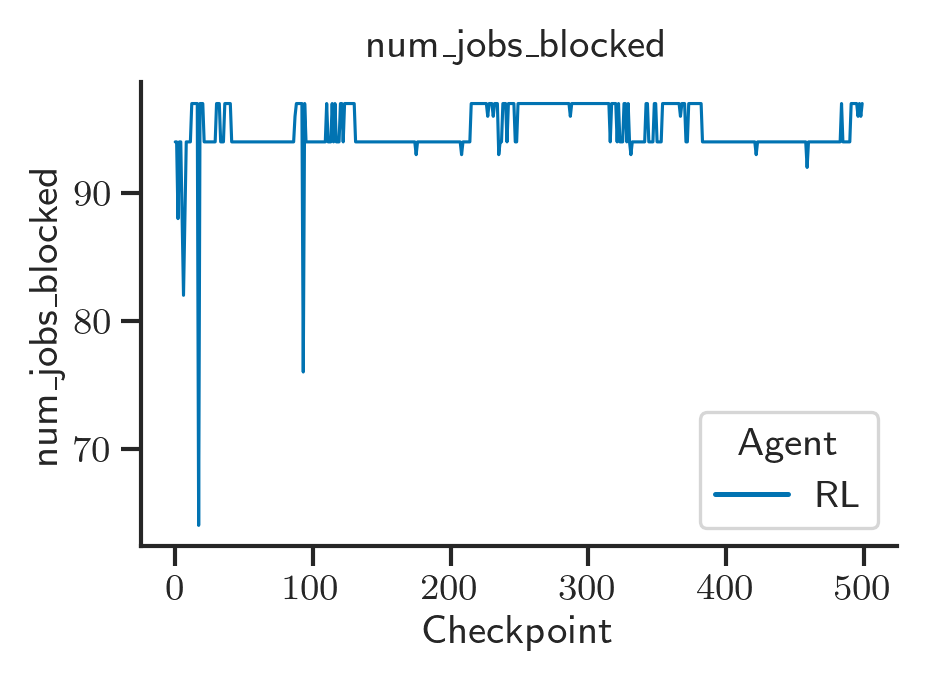

Plotting metric num_jobs_arrived


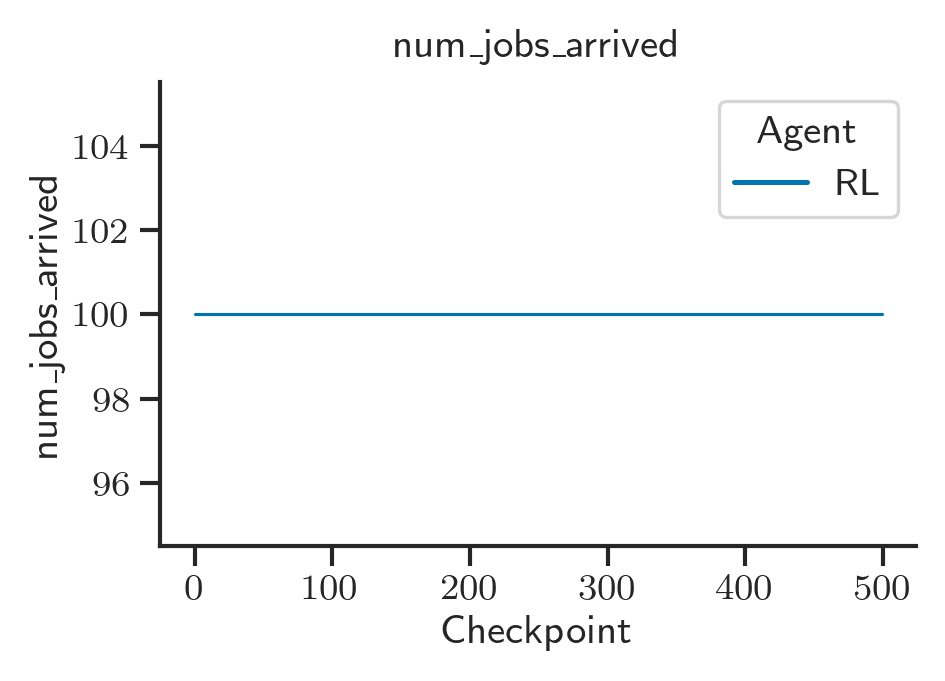

Plotting metric num_jobs_completed


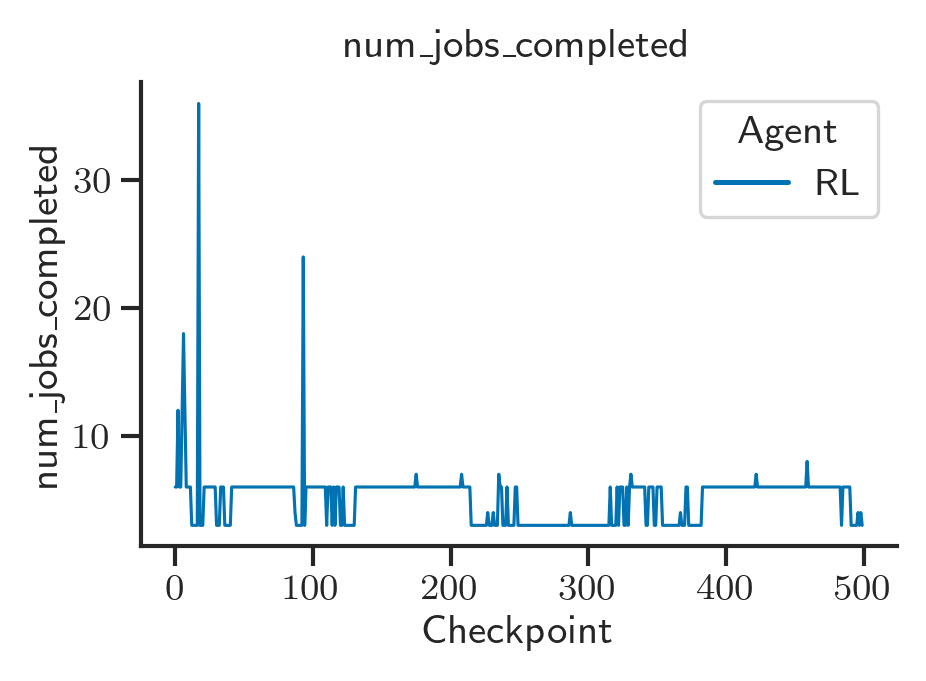

Plotting metric jobs_completed_total_dependency_size


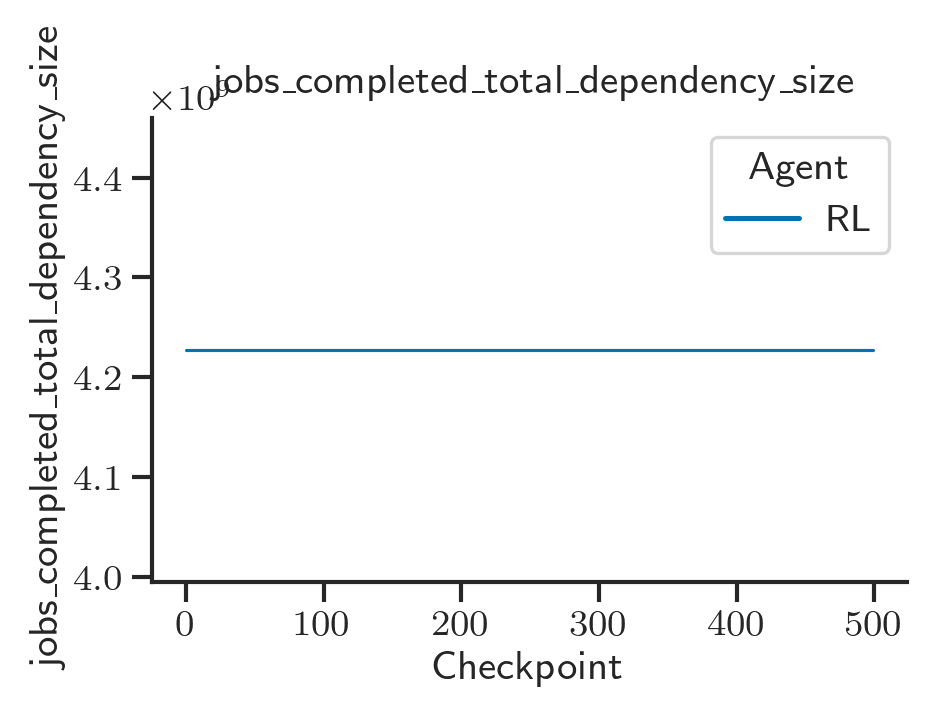

Plotting metric job_completion_time


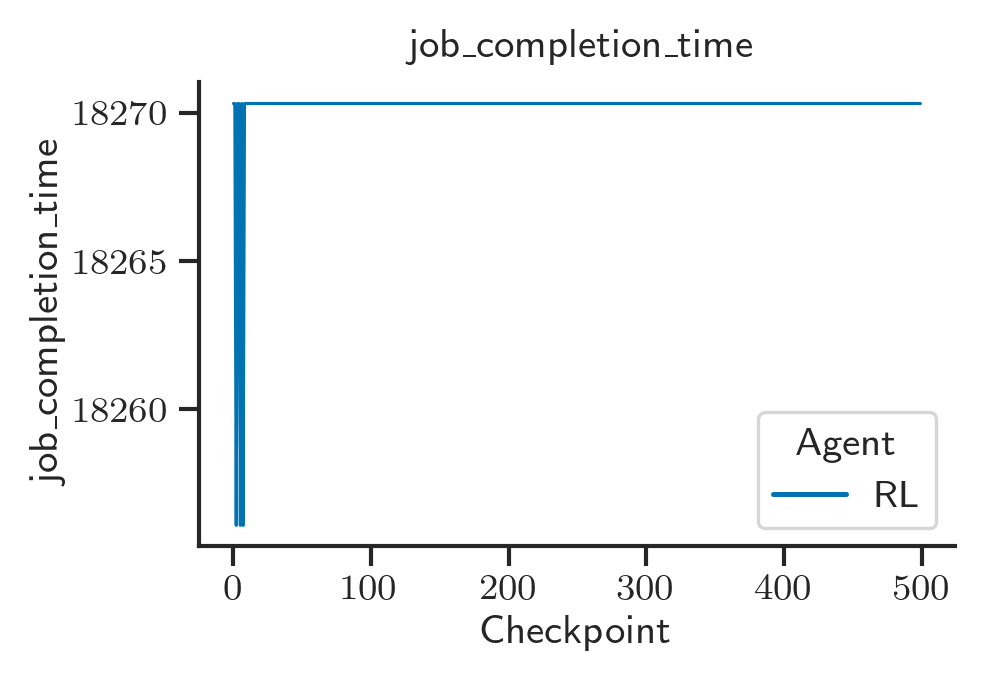

Plotting metric jobs_completed_num_nodes


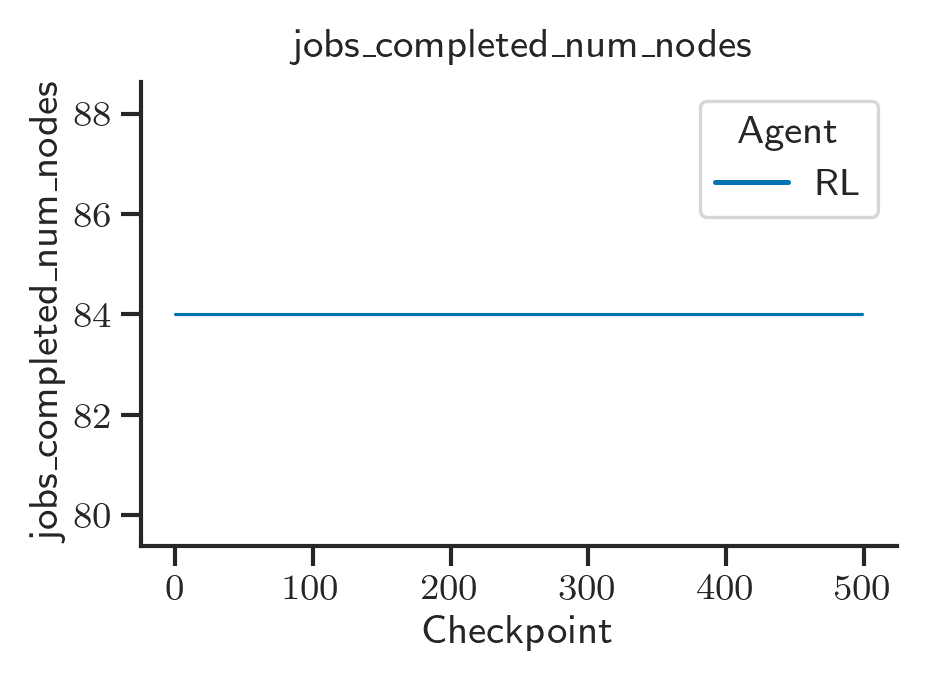

Plotting metric job_communication_overhead_time


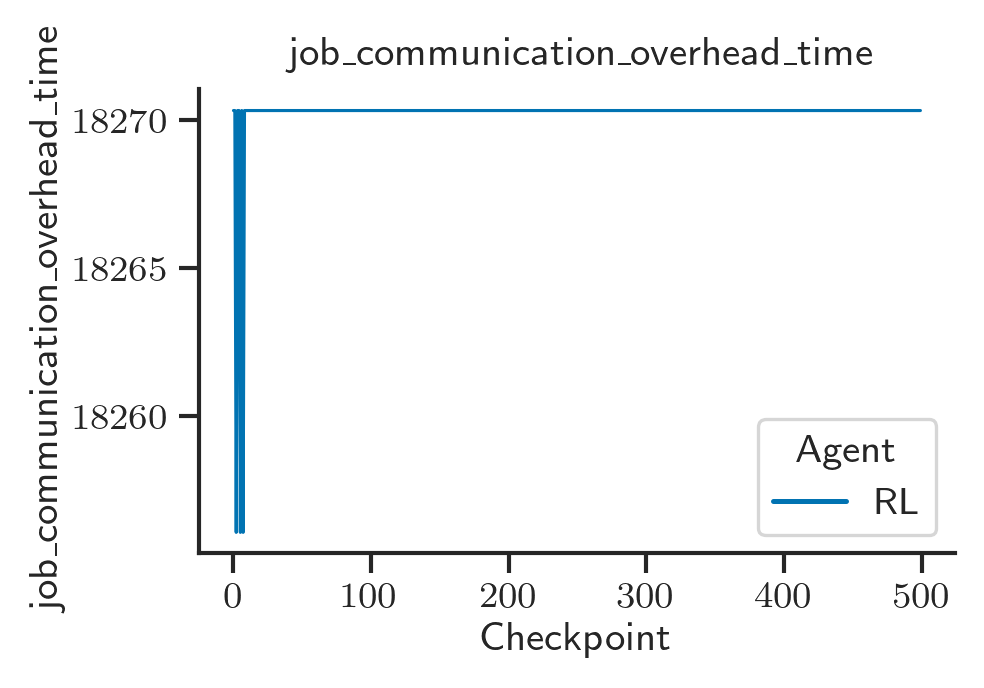

Plotting metric jobs_completed_num_edges


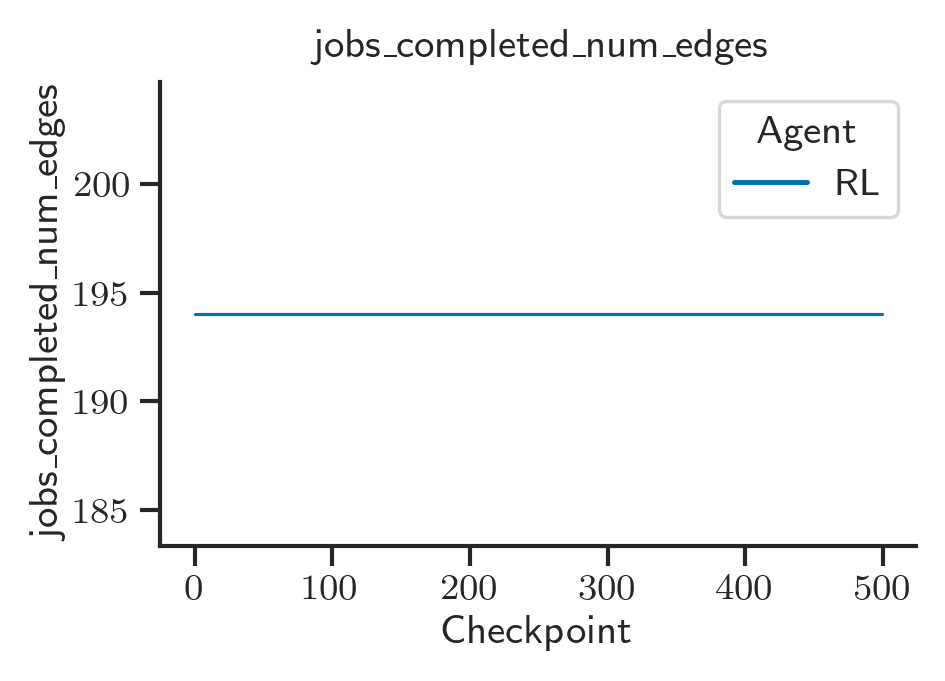

Plotting metric jobs_completed_total_operation_memory_cost


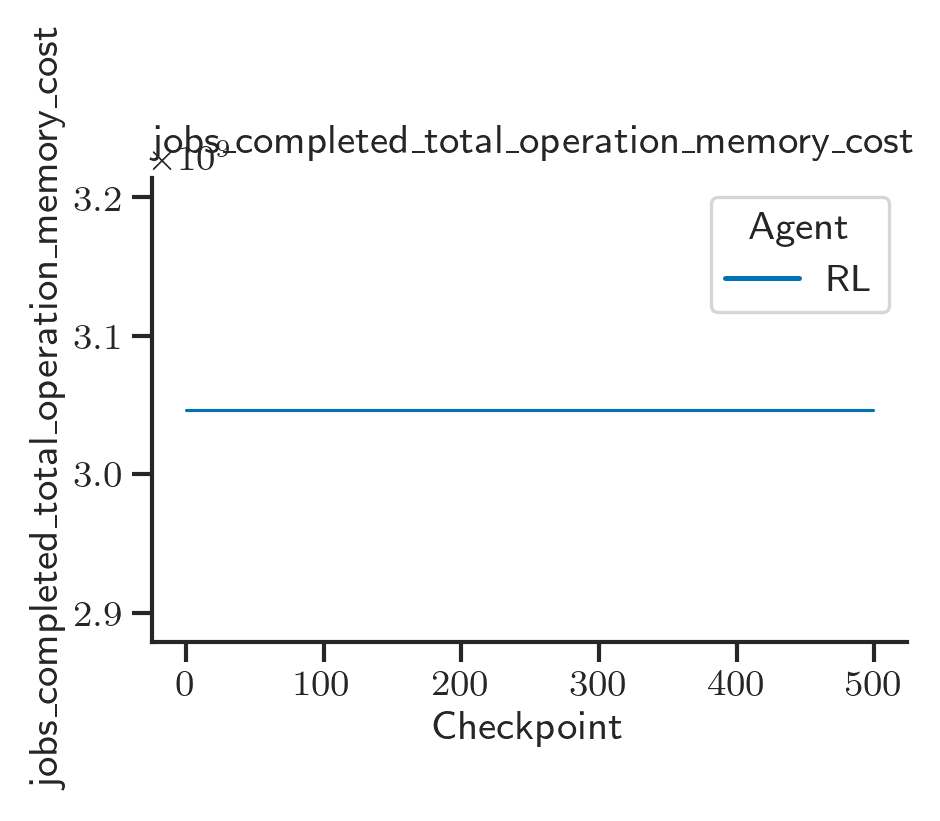

Plotting metric job_computation_overhead_time


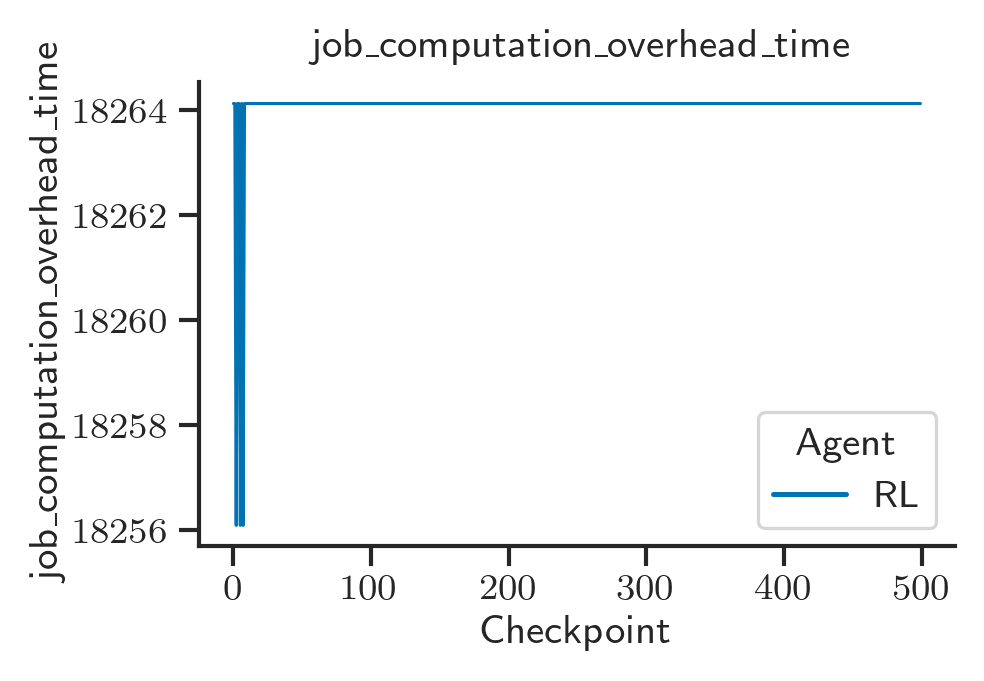

Plotting metric jobs_blocked_num_edges


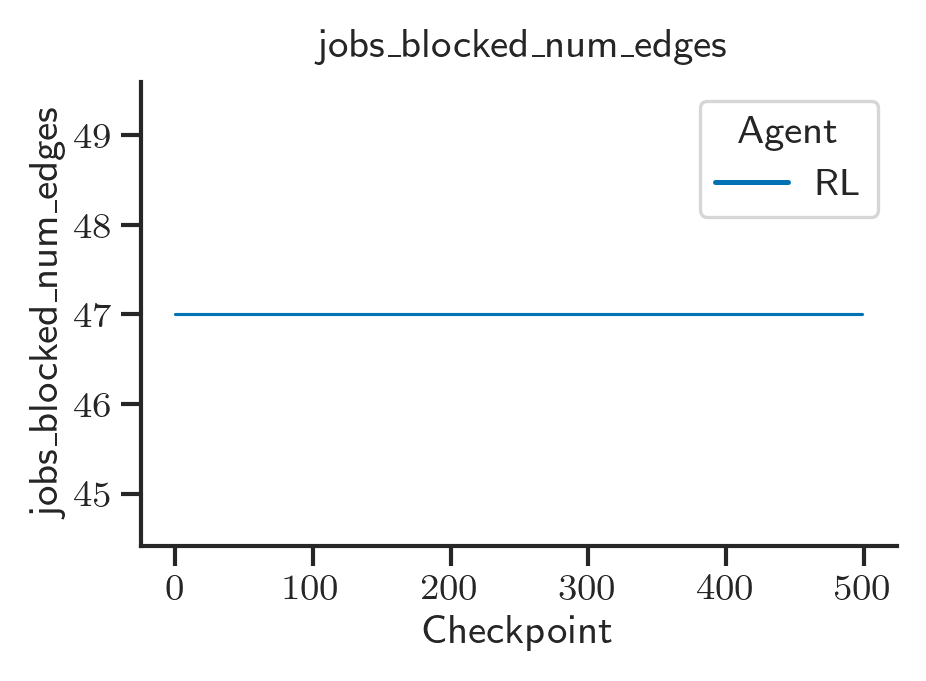

Plotting metric jobs_blocked_total_operation_memory_cost


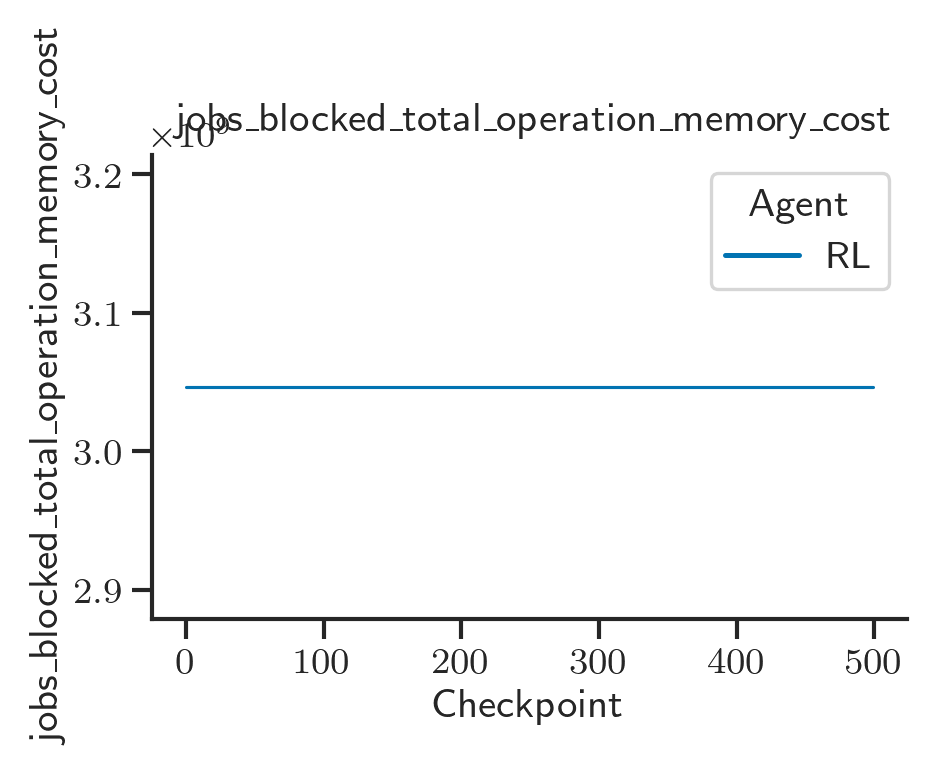

Plotting metric jobs_blocked_num_nodes


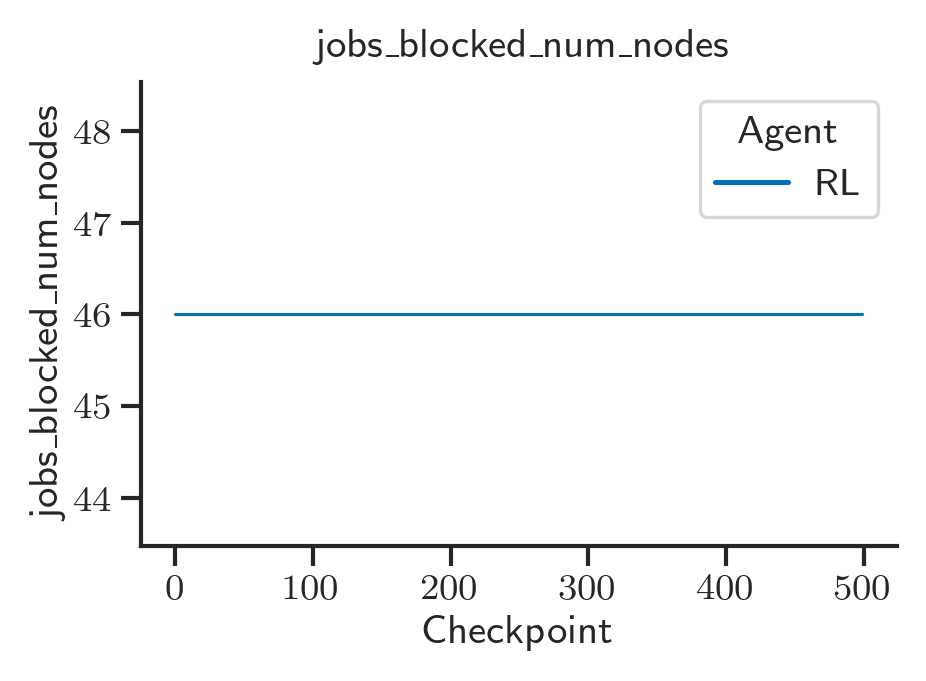

Plotting metric jobs_blocked_total_dependency_size


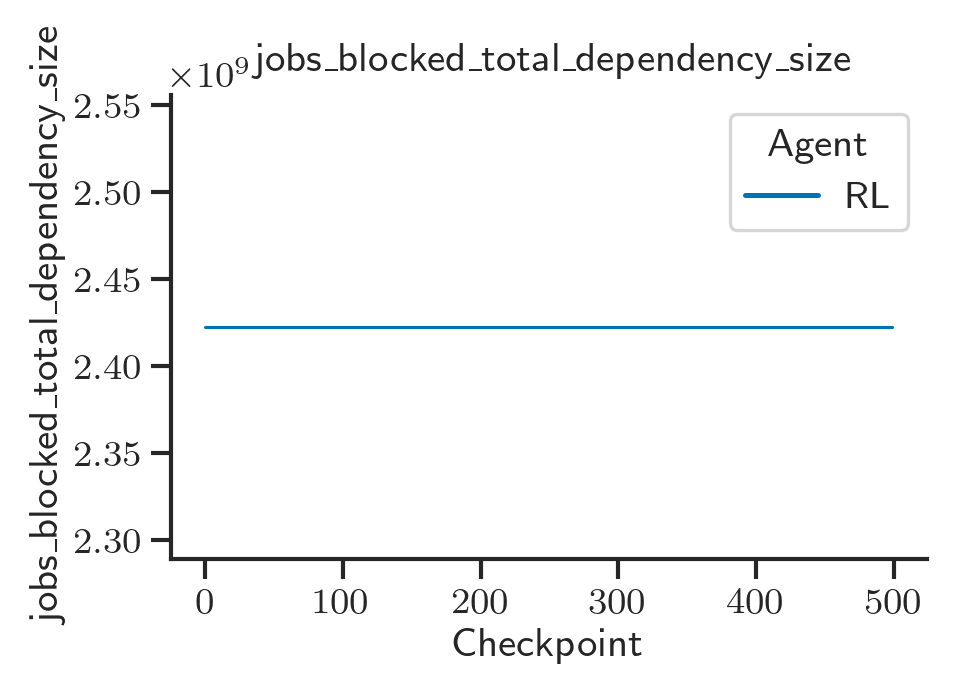



STEP METRICS
Plotting metric mean_comm_overhead_frac


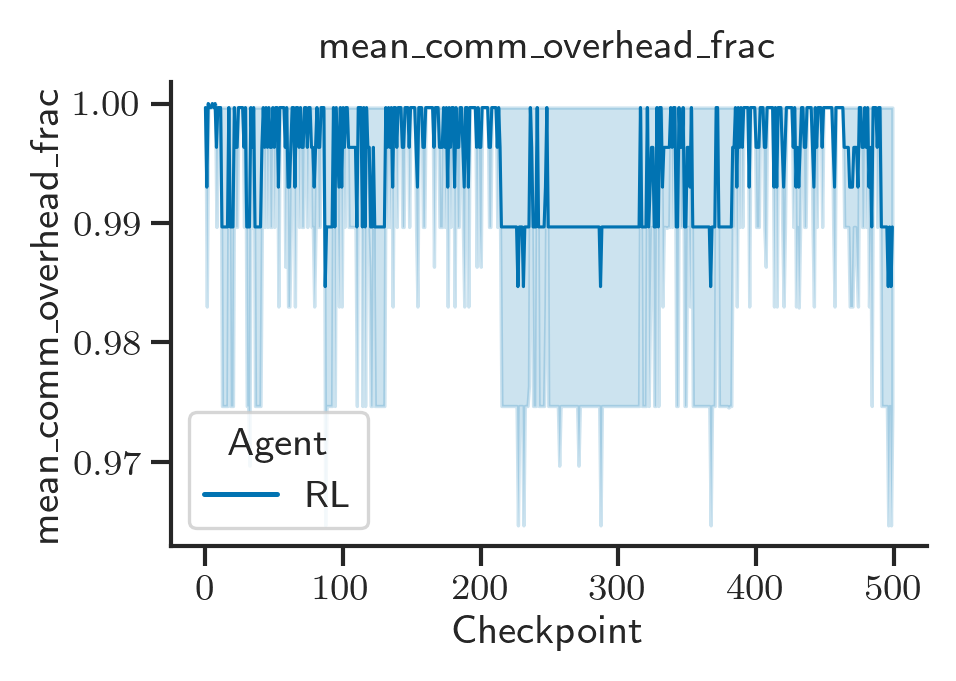

Plotting metric num_jobs_running


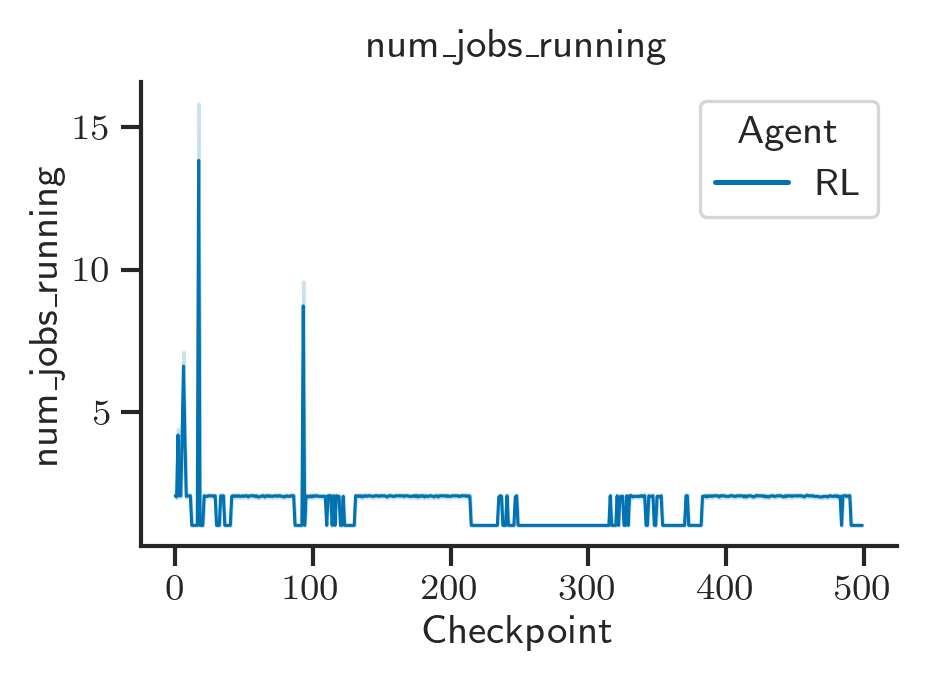

Plotting metric reward


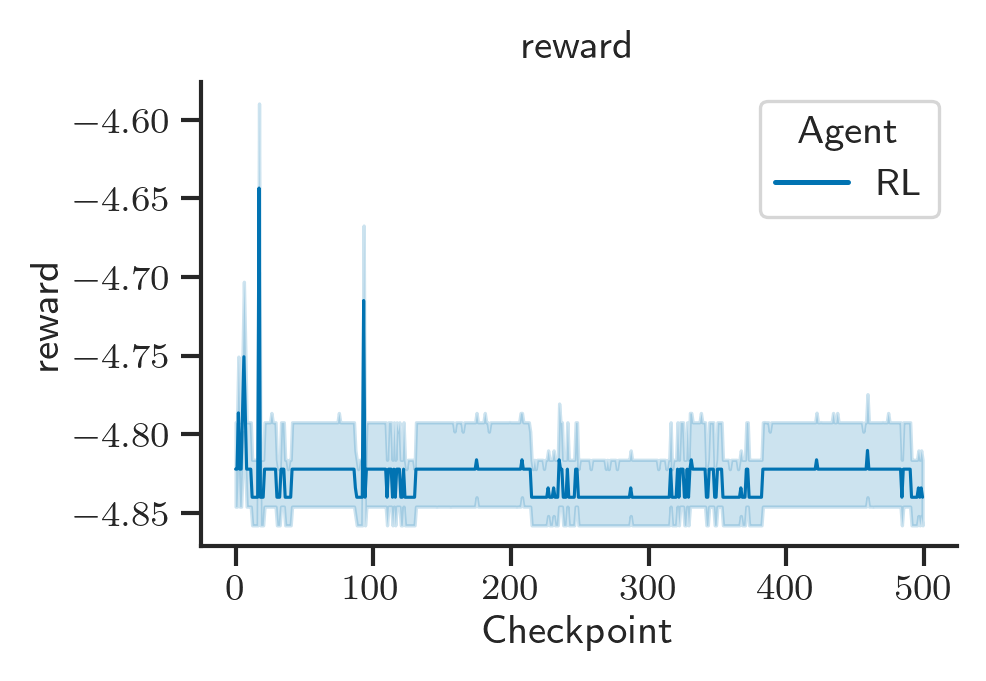

Plotting metric mean_num_mounted_workers


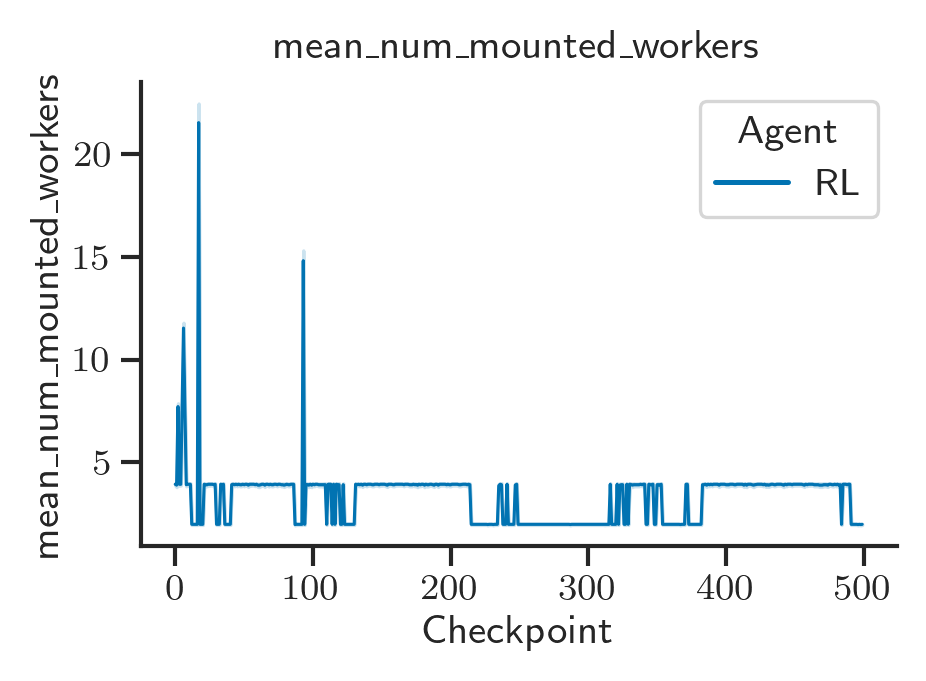

Plotting metric mean_compute_overhead_frac


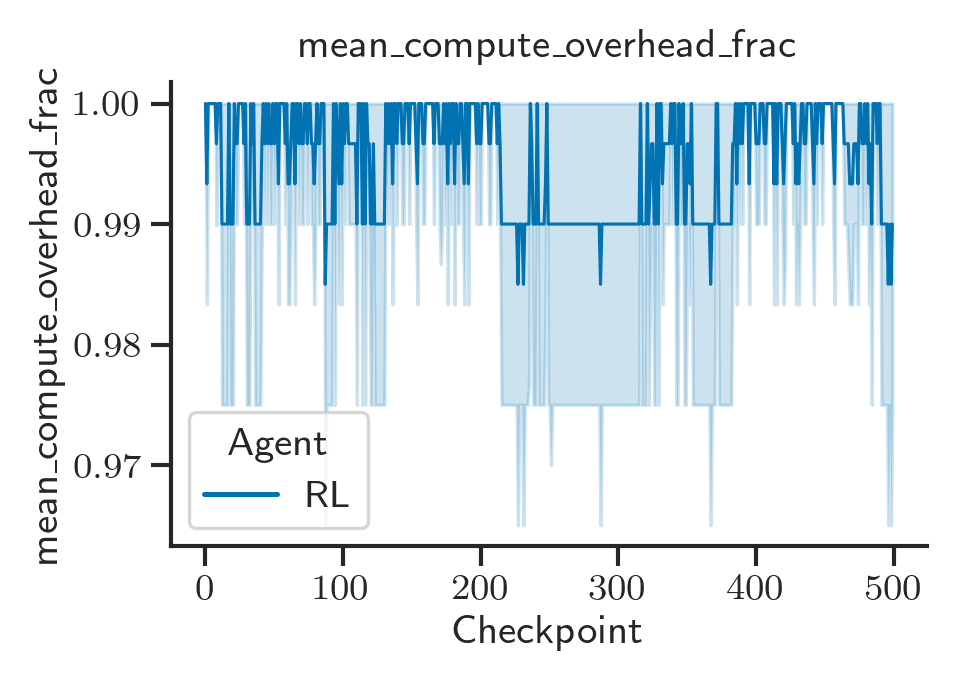

Plotting metric num_jobs_arrived


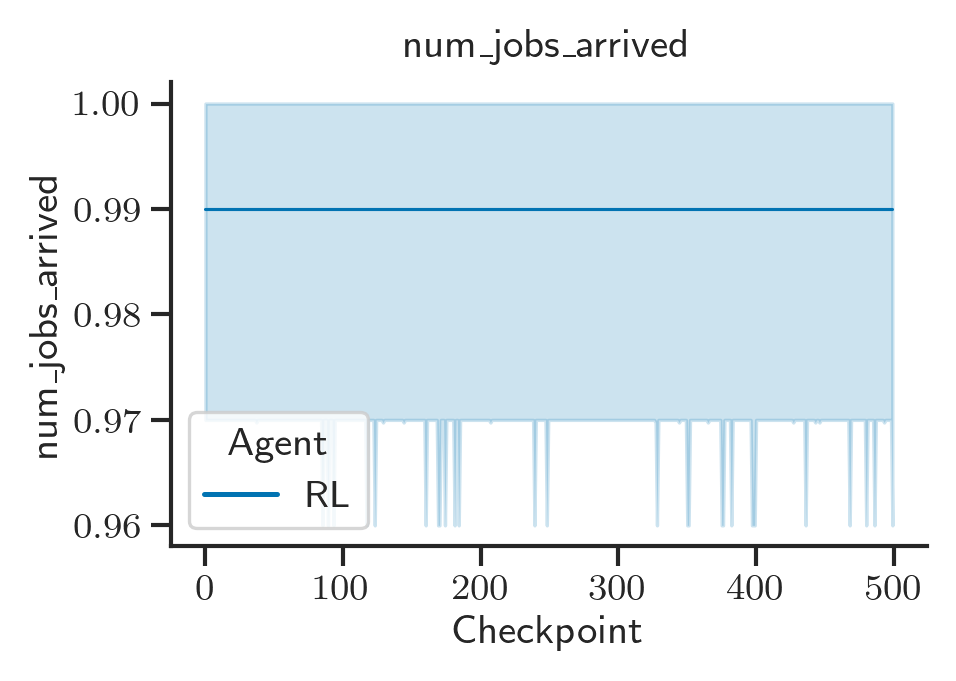

Plotting metric step_end_time


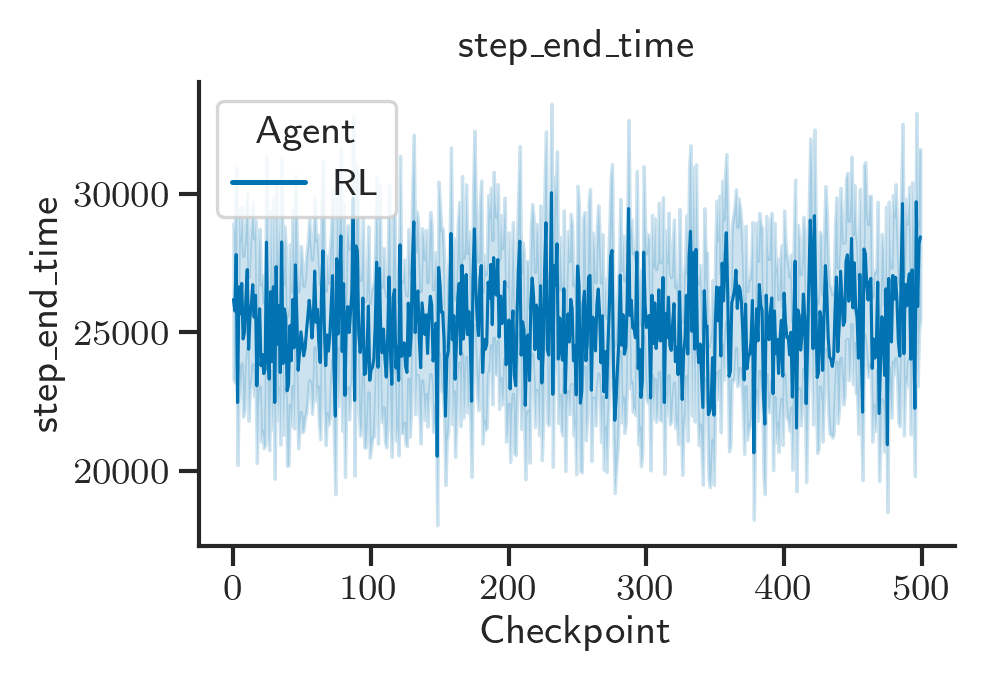

Plotting metric job_queue_length


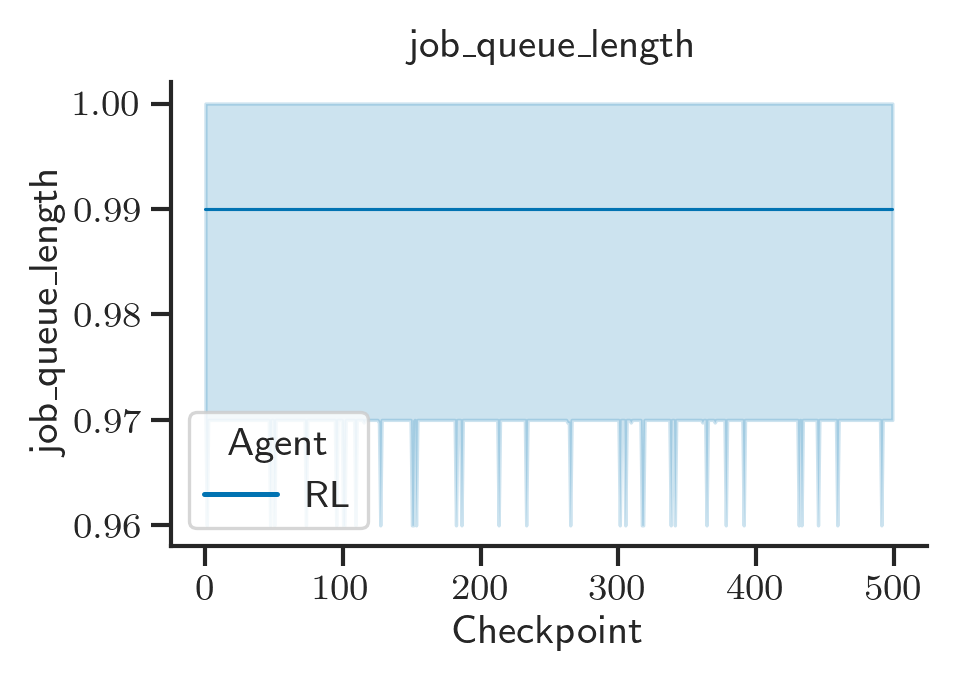

Plotting metric action


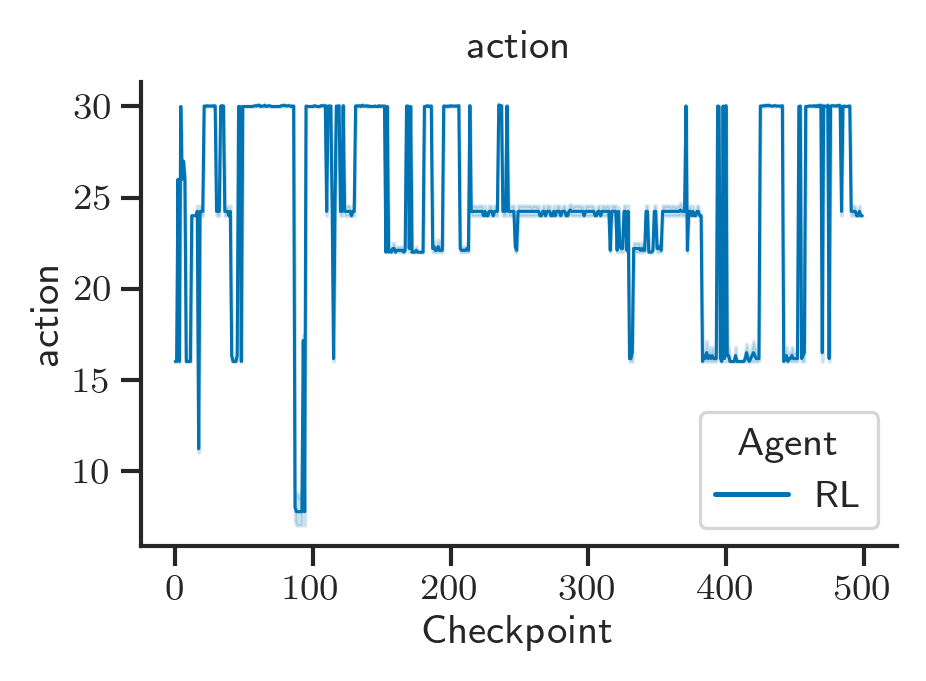

Plotting metric step_counter


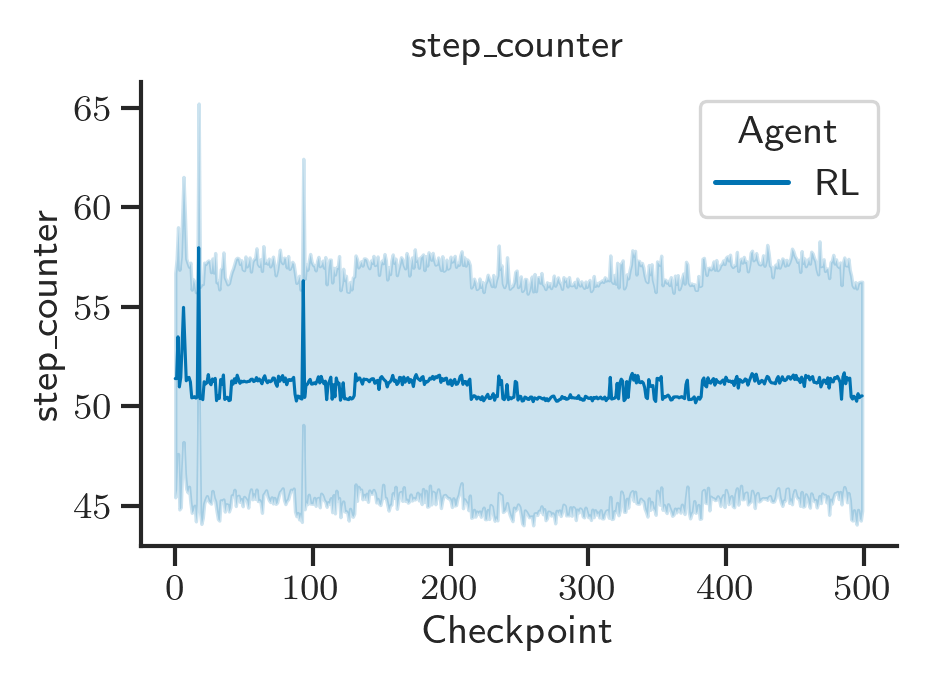

Plotting metric mean_compute_throughput


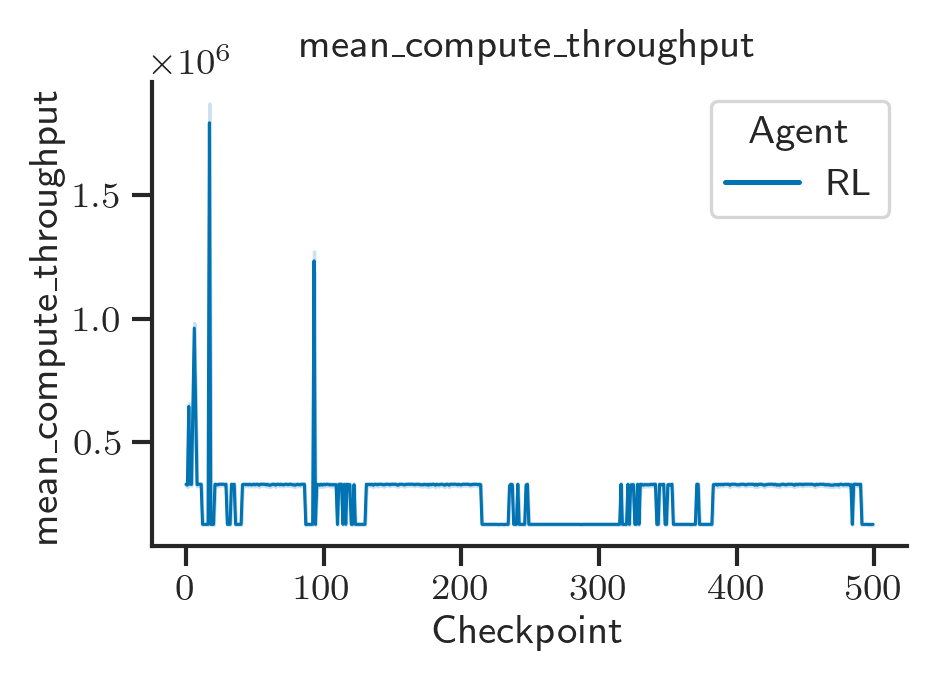

Plotting metric num_jobs_completed


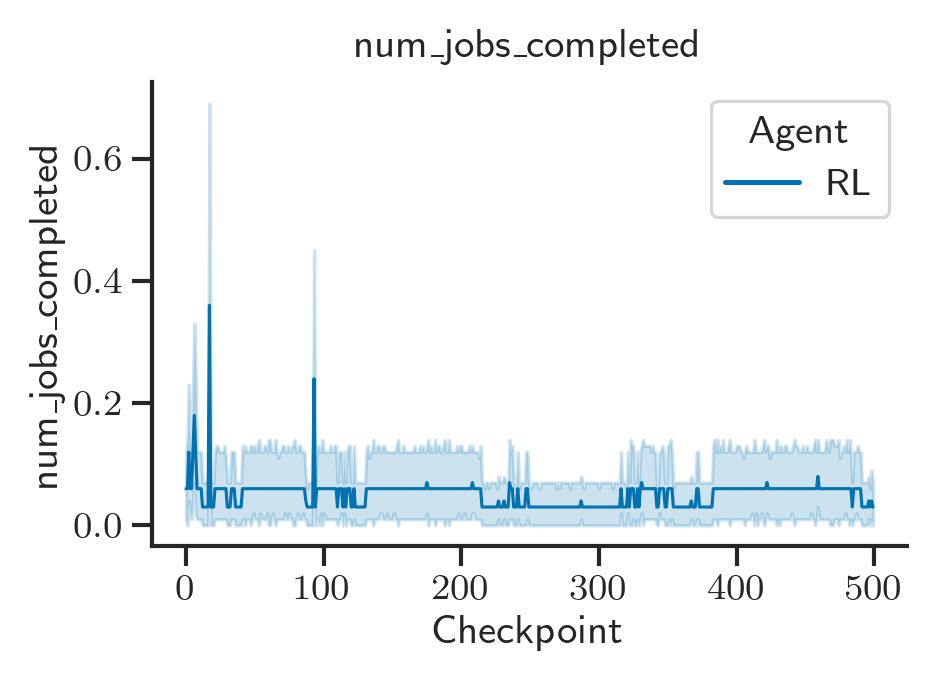

Plotting metric num_jobs_blocked


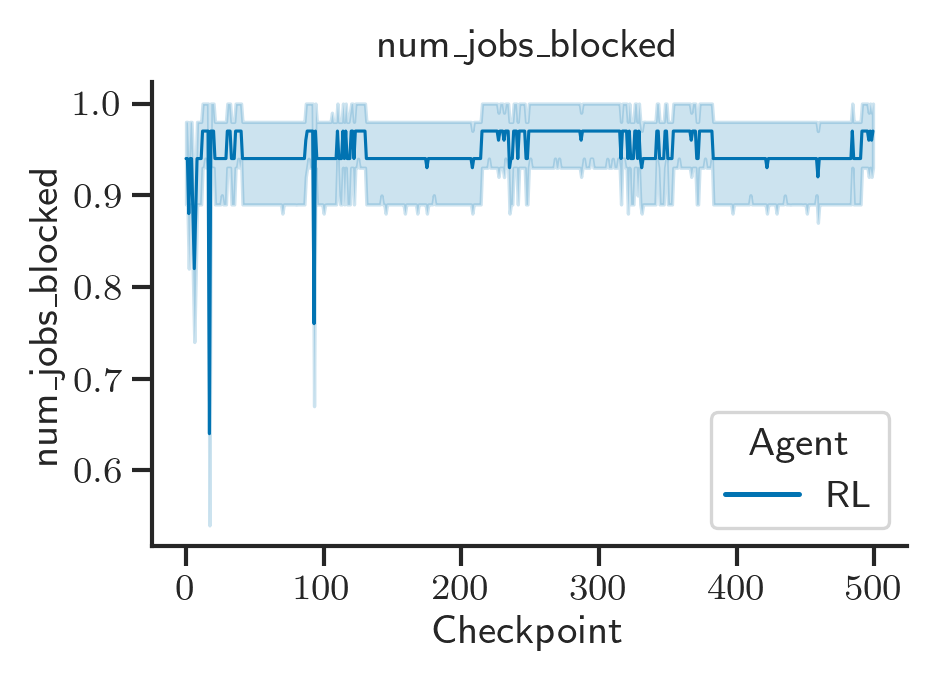

Plotting metric mean_cluster_throughput


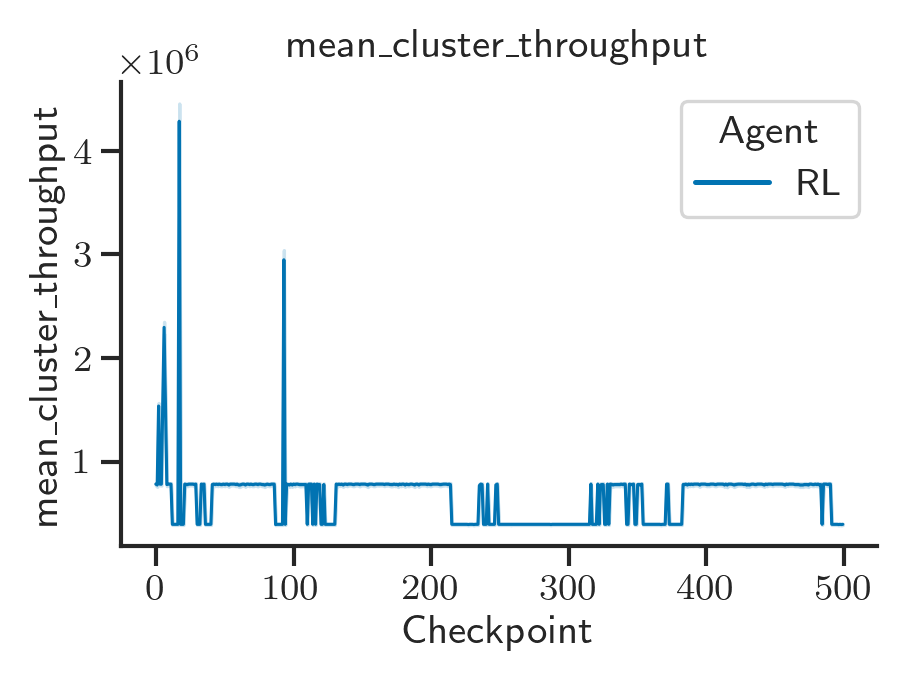

Plotting metric step_start_time


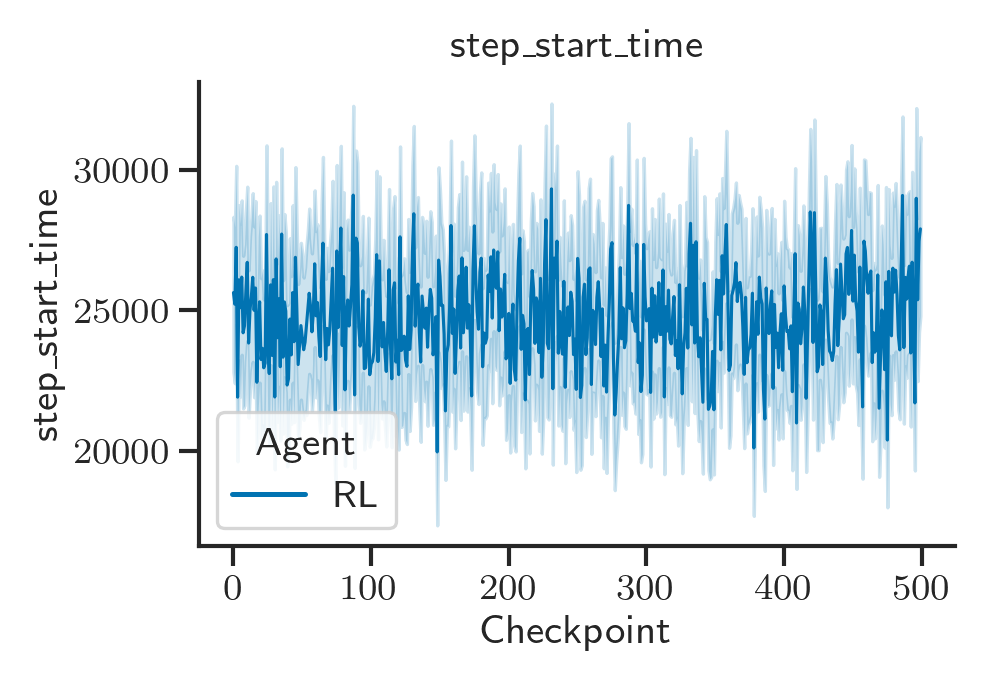

Plotting metric mean_comm_throughput


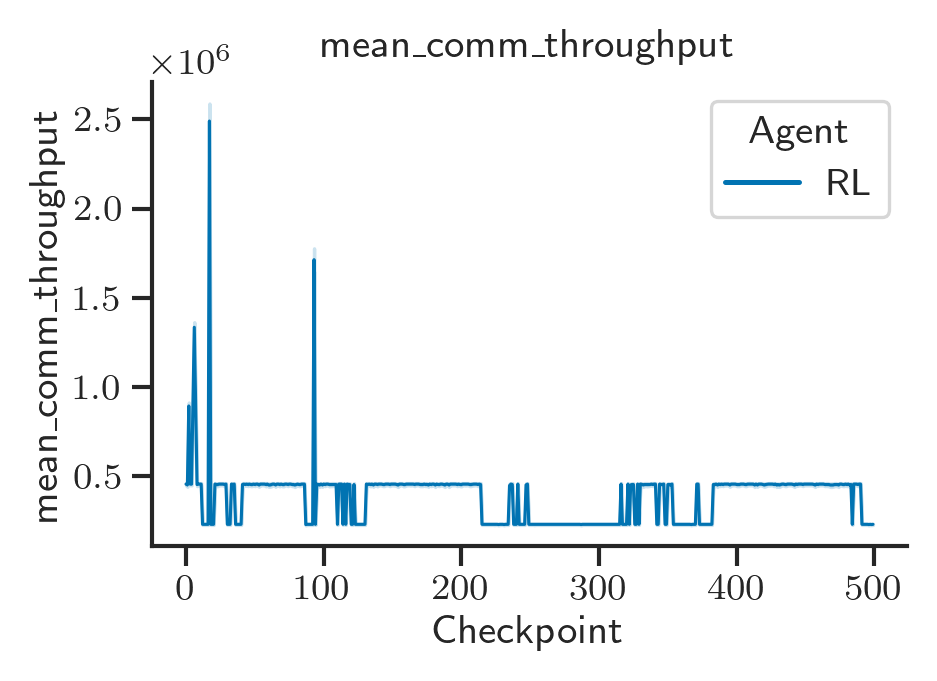

Plotting metric mean_num_mounted_channels


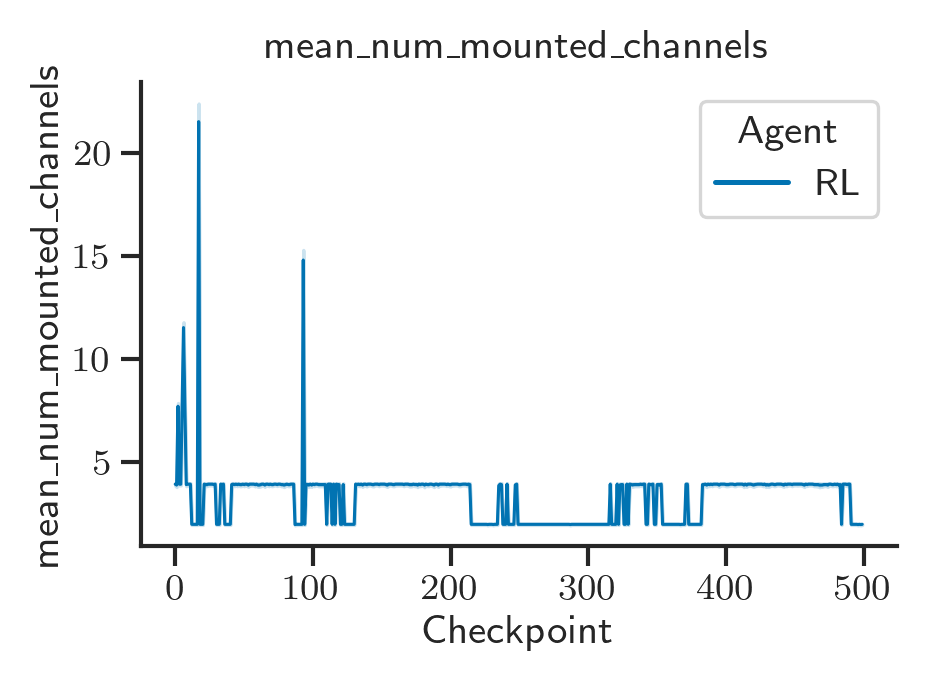

In [188]:
print(f'\n\nEPISODE METRICS')
for metric in episode_metrics:
    lineplot(df=episode_stats_df, metric=metric)
if len(episode_completion_stats_df) > 0:
    for metric in episode_completion_metrics:
        lineplot(df=episode_completion_stats_df, metric=metric)
if len(episode_blocked_stats_df) > 0:
    for metric in episode_blocked_metrics:
        lineplot(df=episode_blocked_stats_df, metric=metric)
    
print(f'\n\nSTEP METRICS')
for metric in step_metrics:
    lineplot(df=step_stats_df, metric=metric)